In [32]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *
from models.scorenetwork import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
from itertools import chain
from tqdm import tqdm
from IPython.display import HTML
from IPython.display import clear_output

/tmp/ipykernel_671748/3475194806.py:11: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [33]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
total_iteration = 1000
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.5
batch_size = 1000
dataloader = torch.utils.data.DataLoader(Cluster2DataSet(dist1, dist2, probability=probability, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

## Real Samples

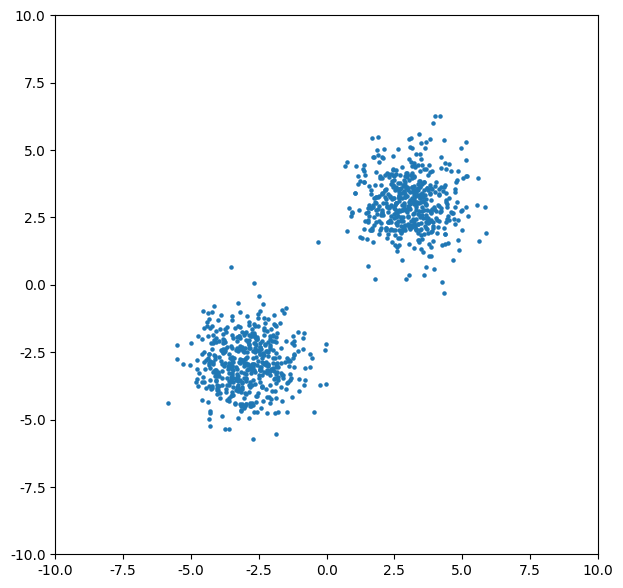

In [35]:
scatter(next(iter(dataloader)), True)

In [36]:
scatter_range = [-10, 10]
total_iteration = 2000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
# score network parameters
eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100

In [37]:
learning_rate = 5e-3
z_dim = 2
sample_dir = './results/clusters2_DAE'
lamd = 5000

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Traning DAE

In [38]:
sigma =  5.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

vae = VAE(input_size=2, h_dim=256, z_dim=z_dim, type='mse').to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

sn = SN_Model(marginal_prob_std=marginal_prob_std_fn, embed_dim=10, dim=2, drop_p=0.3, device=device)
# sn = SN_Model(device, n_steps, sigma_min, sigma_max, dim=z_dim, p = 0.3)
sn_optim = torch.optim.Adam(sn.parameters(), lr = 0.005)
# dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)

joint_optim = torch.optim.Adam(params=chain(vae.parameters(), sn.parameters()))

torch.multiprocessing.set_start_method('spawn', force=True)

joint_training = True

# Start training
tqdm_epoch = tqdm(range(total_iteration))
for i in tqdm_epoch:
    try:
        data = next(dataiterator)
    except:
        dataiterator = iter(dataloader)
        data = next(dataiterator)
    data = data.to(device = device)

    if joint_training:
        mu, log_var = vae.encode(data)
        z = vae.reparameterize(mu, log_var)

        # no diffusion process
        x_reconst = vae.decode(z, type='mse')

        # use the forward process as part of the encoder
        # z_ = forward_proc(z, sigma_min, sigma_max, n_steps, device=device, only_final=True)
        # x_reconst = vae.decode(z_)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.mse_loss(x_reconst, data)

        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss_sn = sn.loss(z)
        loss = loss_sn + lamd*reconst_loss + kl_div

        joint_optim.zero_grad()
        loss.backward()
        joint_optim.step()
    else:
        #============= First Stage: Update VAE ==============#
        x_reconst, mu, log_var = vae(data)

        # Compute reconstruction loss and kl divergence
        reconst_loss = F.mse_loss(x_reconst, data)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss_vae = lamd*reconst_loss + kl_div
        vae_optimizer.zero_grad()
        loss_vae.backward()
        vae_optimizer.step()

        #============= Second Stage: Update SN ==============#
        mu, log_var = vae.encode(data)
        z = vae.reparameterize(mu, log_var)

        loss_sn = sn.loss(z)
        vae_optimizer.zero_grad()
        sn_optim.zero_grad()
        loss_sn.backward()
        sn_optim.step()

    if (i+1) % 100 == 0:
        tqdm_epoch.set_description("Iteration[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Diffuse loss: {:.4f}"
                .format(i+1, total_iteration, reconst_loss.item(), kl_div.item(), loss_sn.item()))

        with torch.no_grad():
            # save the reconst images (rebuild the input)
            out, _, _ = vae(data)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'reconst-{}.png'.format(i+1)))
            # Save the sampled images (decode the noise)
            z_sample = torch.randn(batch_size, z_dim).to(device)
            out = vae.decode(z_sample, type='mse')
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'sampled-{}.png'.format(i+1)))
            # Save the diffused images
            # dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps) # cannot be removed
            # sample = dynamic.sampling(sampling_number, z_dim, only_final=True)
            # sample = forward_process(z, marginal_prob_std_fn, batch_size, num_steps=10, device=device, only_final=True)
            sample = Euler_Maruyama_sampler(sn, marginal_prob_std_fn, diffusion_coeff_fn, batch_size, num_steps=100, device=device)
            # z_ = forward_proc(z, sigma_min, sigma_max, n_steps, device=device, only_final=True)
            # sample = dynamic.sampling(sampling_number, z_dim, sample=z_, only_final=True)
            out = vae.decode(sample, type='mse')
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'diffused-{}.png'.format(i+1)))
            plt.close('all')

Iteration[2000/2000], Reconst Loss: 0.1927, KL Div: 2773.2812, Diffuse loss: 919.2483: 100%|██████████| 2000/2000 [01:58<00:00, 16.83it/s] 


## Plot the hidden representation z

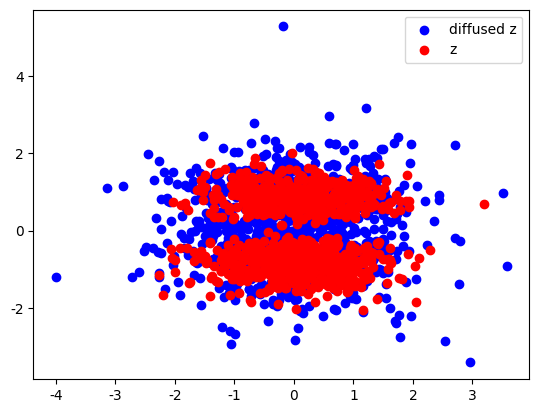

In [39]:
plt.scatter(sample[:,0].cpu().numpy(), sample[:,1].cpu().numpy(), c='b', label='diffused z')
plt.scatter(z[:,0].detach().cpu().numpy(), z[:,1].detach().cpu().numpy(), c='r', label='z')
plt.legend()

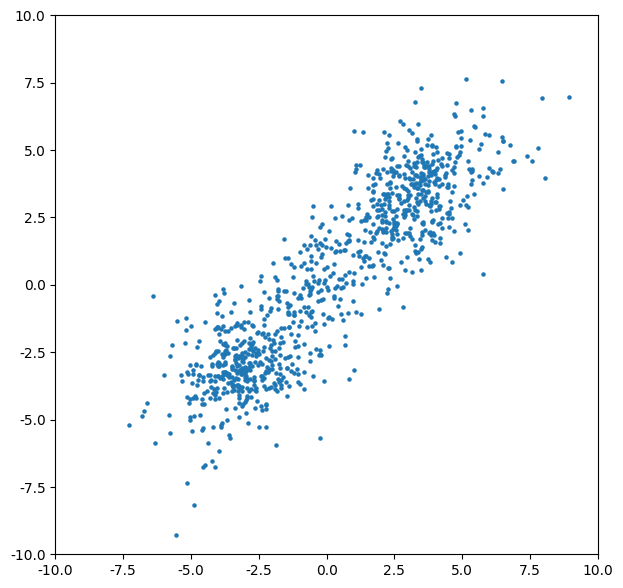

In [40]:
# no diffusion process
x_reconst = vae.decode(sample, type='mse')
scatter(x_reconst, only_final, scatter_range = scatter_range)

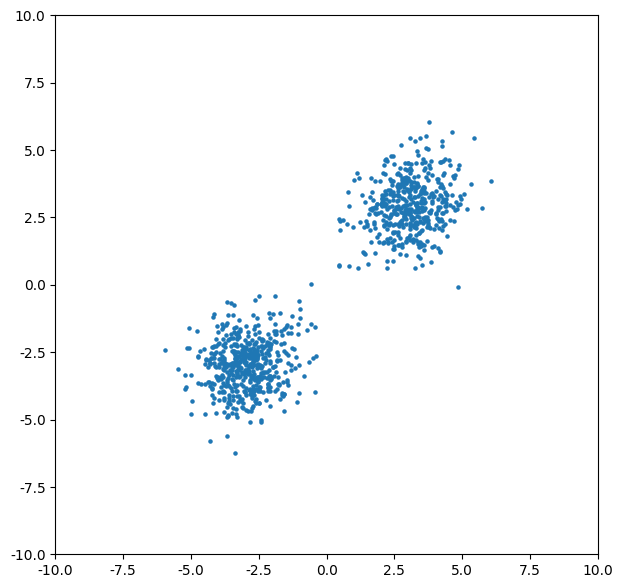

In [41]:
# no diffusion process
x_reconst = vae.decode(z, type='mse')
scatter(x_reconst, only_final, scatter_range = scatter_range)

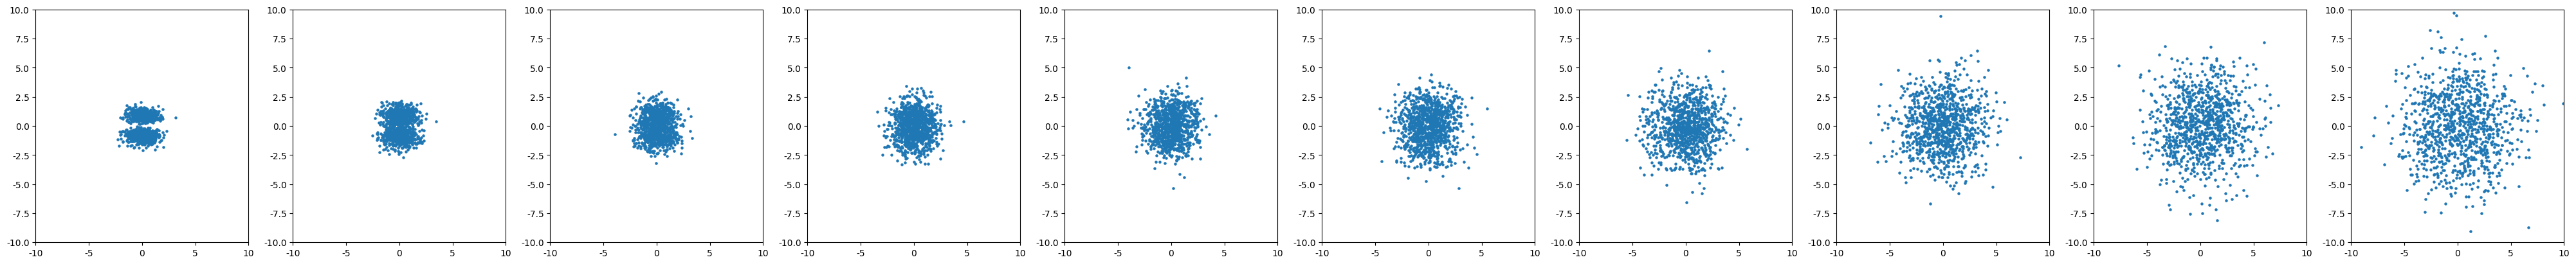

In [42]:
# Diffusion process of the latent variable z
sampling_number = 1000

# dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
# sample = dynamic.sampling(sampling_number, z_dim, only_final=False)
sample = forward_process(z, marginal_prob_std_fn, batch_size, num_steps=10, device=device, only_final=False)
diffuse_data = vae.decode(sample, type='mse')
scatter(sample, only_final=False)

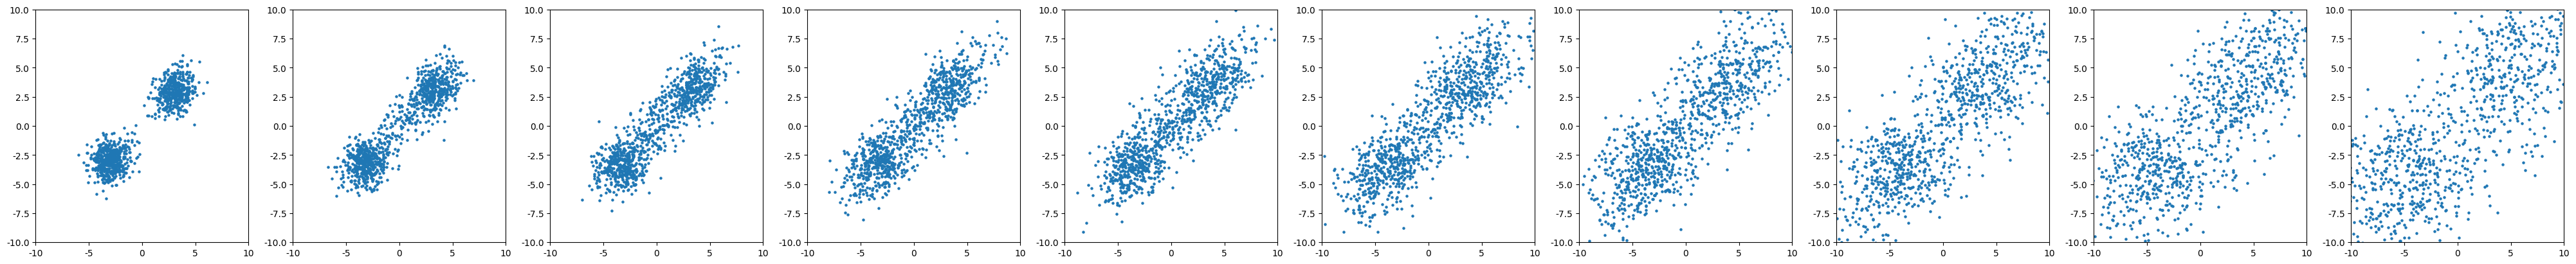

In [43]:
# diffuse_data = vae.decode(z)
scatter(diffuse_data, only_final=False)